### Note

Version 1과 다른 점
- 각종 데이터셋 파라미터와 하이퍼파라미터(ex. LoRA Scaling Factor)를 수정 후 학습
- Regularization 추가
- 성능 지표 추가

목적
- 조금 더 일반화된 성능 도출 

### 0. 라이브러리

In [1]:
import os

# OS 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [60]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchsummary import summary

from torchvision import transforms

import transformers
from transformers import AutoTokenizer, AutoModel, ViTFeatureExtractor, ViTModel, get_linear_schedule_with_warmup

from peft import get_peft_model, LoraConfig, TaskType

In [3]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
fixSEED(seed=seed)

In [4]:
# 디렉토리 설정
dir = 'Python_Programs'
path = '/home/leesanghyuk2000/' + dir
os.chdir(path)
print('Current path {}'.format(os.getcwd()))

Current path /home/leesanghyuk2000/Python_Programs


In [5]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 썸네일 데이터 압축 해제

In [6]:
def unzip_file(zip_path, extract_path):
    # 압축 해제할 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    # zipfile 모듈을 사용하여 압축 해제
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print(f'Complete Unzipping to {extract_path}')

In [7]:
# 압축 해제할 경로 설정
zip_file_path = 'Thumbnails.zip'
extract_to_path = 'Thumbnails'

# 함수적용
unzip_file(zip_file_path, extract_to_path)

Complete Unzipping to Thumbnails


### 2. 텍스트 데이터 가져오기

In [8]:
# 데이터 불러오기
with open('youtubeData(8331)_with_label.pkl', 'rb') as f:
    data = pickle.load(f)

### 3. 썸네일이 없는 경우 확인

In [10]:
# 썸네일 이미지가 없는 데이터 있는지 확인
data[data['saved'] == 0]

,youtuber,my_label,channel_id,title,video_id,thumbnail,content,saved,label


In [11]:
# 열 생성
data['drive_saved'] = 0

# 썸네일 파일 경로
thumbnail_path = 'Thumbnails/Thumbnails'

# 각 video_id에 대해 파일 존재 여부 확인
for i in tqdm(data.index, desc="Checking thumbnails"):
    video_id = data.at[i, 'video_id']
    file_path = os.path.join(thumbnail_path, f"{video_id}.jpg")
    if os.path.isfile(file_path):
        data.at[i, 'drive_saved'] = 1

Checking thumbnails: 100%|██████████| 8331/8331 [00:00<00:00, 20018.51it/s]


In [12]:
# 확인
data['drive_saved'].value_counts()

drive_saved
1    8331
Name: count, dtype: int64

In [13]:
# 레이블 개수 확인
data['label'].value_counts()

label
0    5208
1    3123
Name: count, dtype: int64

### 4. Train/Valid/Test 분리

In [14]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['label'])
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED, stratify = train_val_data['label'])

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [15]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 4998개 
검증용 데이터 개수 : 1666개 
평가용 데이터 개수 : 1667개


### 5. Datasets 및 Dataloader 정의

In [16]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [17]:
# Multi-modal Dataset
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, text_tokenizer, max_length, feature_extractor, image_path, transform=None):
        self.data = dataframe
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.feature_extractor = feature_extractor
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        title = self.data.iloc[idx]['title'] # 제목
        content = self.data.iloc[idx]['content'] # 내용
        text = title + ' ' + content # 제목 + 내용
        video_id = self.data.iloc[idx]['video_id'] # 영상 ID
        label = self.data.iloc[idx]['label']

        # text 토크나이저
        text_inputs = self.text_tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        input_ids = text_inputs['input_ids'].squeeze(0)
        attention_mask = text_inputs['attention_mask'].squeeze(0)

        # image 불러오기 및 전처리
        img_path = os.path.join(self.image_path, f"{video_id}.jpg")
        if self.transform is not None:
            image = self.transform(Image.open(img_path))
        else:
            image = Image.open(img_path)

        # image Feature Extract
        image_inputs = self.feature_extractor(images=image, return_tensors='pt')
        pixel_values = image_inputs['pixel_values'].squeeze(0)

        return input_ids, attention_mask, pixel_values, torch.tensor(label, dtype=torch.long)  # 정수형

### 6. 모델 정의

In [24]:
class MultiModalBERT(nn.Module):
    def __init__(self, text_checkpoint, vision_checkpoint, lora_r=8, lora_alpha=1, lora_dropout=0.1):
        super(MultiModalBERT, self).__init__()

        # Pre-trained model for text and image
        self.text_model = AutoModel.from_pretrained(text_checkpoint, output_hidden_states=True) # 모델은 Model을 사용
        self.img_model = ViTModel.from_pretrained(vision_checkpoint) # 모델은 Model을 사용

        # LoRA Config for text model
        text_config = LoraConfig(
            target_modules=["query", "key", "value"],  # Apply LoRA to the all attention layers
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout
        )

        # LoRA Config for image model
        img_config = LoraConfig(
            target_modules=["query", "key", "value"],  # Apply LoRA to the all attention layers
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
        )

        # Apply LoRA to each models
        self.text_model = get_peft_model(self.text_model, text_config)
        self.img_model = get_peft_model(self.img_model, img_config)

        # Transformer Encoder for cancat outputs
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.text_model.config.hidden_size + self.img_model.config.hidden_size,
            nhead=8
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1) # 트랜스포머 인코더는 1개만 이용

        # Classifier layer
        self.classifier = nn.Linear(self.text_model.config.hidden_size + self.img_model.config.hidden_size, 2)

        # Dropout
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_ids, attention_mask, pixel_values):
        # Text model 순전파
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_hidden_state = text_outputs.hidden_states[-1][:, 0, :]  # CLS token

        # Image model 순전파
        img_outputs = self.img_model(pixel_values=pixel_values)
        img_hidden_state = img_outputs.last_hidden_state[:, 0, :]  # CLS token

        # image, text 모델의 결과 concat
        concat_hidden_state = torch.cat((text_hidden_state, img_hidden_state), dim=1).unsqueeze(1)

        # concat 결과를 encoder에 전달
        encoded_output = self.transformer_encoder(concat_hidden_state)
        encoded_output = encoded_output[:, 0, :]  # CLS token

        # 드롭아웃 적용
        encoded_output = self.dropout(encoded_output)

        # encoder에 결과를 classifier로 전달
        logits = self.classifier(encoded_output)

        return logits

모델 정의 참고

1. ```VitFeatureExtractor``` : https://velog.io/@heomollang/Pytorch-%ED%97%88%EA%B9%85%ED%8E%98%EC%9D%B4%EC%8A%A4-Feature-Extractor
2. Apply LoRA to ViT : https://huggingface.co/docs/peft/main/en/task_guides/image_classification_lora
3. ```ViTImageProcessor``` : https://huggingface.co/blog/fine-tune-vit
4. LoRA Config ```TaskType``` : https://discuss.huggingface.co/t/task-type-parameter-of-loraconfig/52879/4

### 7. 학습용 Trainer 정의

In [42]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, precision_metric, recall_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.precision_metric = precision_metric  # precision metric
        self.recall_metric = recall_metric  # recall metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience
        
        # 스케줄러 초기화
        total_steps = len(train_dataloader) * num_epochs
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train(self):
        train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history = [], [], [], [], []
        valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = [], [], [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 80)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 80)

            train_loss, train_acc, train_precision, train_recall, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_precision, valid_recall, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_precision_history.append(train_precision)
            train_recall_history.append(train_recall)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_precision_history.append(valid_precision)
            valid_recall_history.append(valid_recall)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t Precision: {train_precision:.4f} \t Recall: {train_recall:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t Precision: {valid_precision:.4f} \t Recall: {valid_recall:.4f} \t F1: {valid_f1:.4f}')
            print(f'(Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s)')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    save_path = f'./YouTube_RoBERTa_ViT_ACC_{valid_acc:.4f}.pth'
                    torch.save(self.model.state_dict(), save_path)
                    print(f'Model Saved to {save_path}')
                except:
                    print('Model Not Saved')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'Early Stopping at Epoch {epoch+1}')
                    break

        return train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_precision = 0
        train_recall = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, pixel_values, y = batch
            input_ids, attention_mask, pixel_values, y = input_ids.to(self.device), attention_mask.to(self.device), pixel_values.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask, pixel_values)
            loss = self.criterion(outputs, y) # 데이터셋에서 레이블을 long으로 정의함

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()  # 스케줄러 업데이트

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_precision += self.precision_metric(preds, y).item()
            train_recall += self.recall_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_precision / len(self.train_dataloader), train_recall / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_precision = 0
        valid_recall = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, pixel_values, y = batch
                input_ids, attention_mask, pixel_values, y = input_ids.to(self.device), attention_mask.to(self.device), pixel_values.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask, pixel_values)
                loss = self.criterion(outputs, y)

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_precision += self.precision_metric(preds, y).item()
                valid_recall += self.recall_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_precision / len(self.valid_dataloader), valid_recall / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)

### 8. 학습 설정

In [43]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 64

# text 토크나이저 정의
text_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(text_checkpoint)

# image 프로세서 정의
vision_checkpoint = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(vision_checkpoint)

# image 경로
image_path = 'Thumbnails/Thumbnails'

In [44]:
# 이미지 전처리 객체
transform = transforms.Compose(
    [
        transforms.Resize([256, 256]), # 이미지를 크기를 조정
        #transforms.RandomCrop([224, 224]), # 이미지를 랜덤하게 자르기
        #transforms.RandomResizedCrop(256), # 이미지를 랜덤한 크기로 자르고 크기를 조정
        transforms.RandomHorizontalFlip(), # 이미지를 랜덤하게 수평으로 뒤집기
        transforms.RandomVerticalFlip(), # 이미지를 랜덤하게 수직으로 뒤집기
        #transforms.RandomRotation(45), # 이미지를 랜덤하게 회전
        transforms.ToTensor(), # 이미지를 텐서로 변환
        #transforms.Grayscale(num_output_channels=1), # 이미지를 흑백으로 변환
        #transforms.Normalize((0.5,), (0.5,)), # 이미지를 정규화(ToTensor 다음에 사용)
        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1) # 이미지의 밝기, 대비, 채도, 색상을 무작위로 조정
])

In [45]:
# 데이터셋 정의
train_dataset = MultiModalDataset(train_data, tokenizer, max_length, feature_extractor, image_path, transform)
valid_dataset = MultiModalDataset(valid_data, tokenizer, max_length, feature_extractor, image_path, transform)
test_dataset = MultiModalDataset(test_data, tokenizer, max_length, feature_extractor, image_path, transform)

In [46]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0,  3629,  2170,  ...,  2069,  3783,     2],
         [    0,  1003,  2762,  ...,   780,  2069,     2],
         [    0, 12718, 30976,  ...,   901,   831,     2],
         ...,
         [    0, 10725,     3,  ...,    23,  2019,     2],
         [    0,  3708,  2069,  ...,  4039, 10256,     2],
         [    0,  7379,  2259,  ..., 15241,  2069,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]],
 
          [[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1.,

### 9. 학습 진행

In [37]:
# Model
model = MultiModalBERT(text_checkpoint, vision_checkpoint)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiModalBERT(
  (text_model): PeftModel(
    (base_model): LoraModel(
      (model): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32000, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (defaul

In [38]:
# LoRA 적용 후 훈련 가능한 파라미터 개수
print_trainable_parameters(model)

Trainable Params: 42032130 
All params: 465077762
--------------------------------------------------
Trainable(%): 9.03766


In [47]:
# 손실함수와 옵티마이저, 그리고 Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)

In [48]:
# 모델 학습 파라미터
num_epochs = 10
wait_for_es = 5

In [49]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  precision_metric,
                  recall_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [50]:
# 학습 시작
train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history = trainer.train()

--------------------------------------------------------------------------------
Epoch 1/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]


[Train] 	 Loss: 0.3142 	 Acc: 0.8752 	 Precision: 0.8675 	 Recall: 0.8048 	 F1: 0.8165
[Valid] 	 Loss: 0.1795 	 Acc: 0.9399 	 Precision: 0.9337 	 Recall: 0.9001 	 F1: 0.9144
(Epoch 1 complete in 3m 28s)
Model Saved to ./YouTube_RoBERTa_ViT_ACC_0.9399.pth
--------------------------------------------------------------------------------
Epoch 2/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]


[Train] 	 Loss: 0.2207 	 Acc: 0.9157 	 Precision: 0.9148 	 Recall: 0.8693 	 F1: 0.8805
[Valid] 	 Loss: 0.1674 	 Acc: 0.9440 	 Precision: 0.8641 	 Recall: 0.9550 	 F1: 0.9048
(Epoch 2 complete in 6m 58s)
Model Saved to ./YouTube_RoBERTa_ViT_ACC_0.9440.pth
--------------------------------------------------------------------------------
Epoch 3/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]


[Train] 	 Loss: 0.1589 	 Acc: 0.9393 	 Precision: 0.9329 	 Recall: 0.9084 	 F1: 0.9157
[Valid] 	 Loss: 0.1026 	 Acc: 0.9670 	 Precision: 0.9688 	 Recall: 0.9359 	 F1: 0.9507
(Epoch 3 complete in 10m 28s)
Model Saved to ./YouTube_RoBERTa_ViT_ACC_0.9670.pth
--------------------------------------------------------------------------------
Epoch 4/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]


[Train] 	 Loss: 0.1418 	 Acc: 0.9459 	 Precision: 0.9441 	 Recall: 0.9138 	 F1: 0.9242
[Valid] 	 Loss: 0.0887 	 Acc: 0.9711 	 Precision: 0.9713 	 Recall: 0.9510 	 F1: 0.9588
(Epoch 4 complete in 13m 58s)
Model Saved to ./YouTube_RoBERTa_ViT_ACC_0.9711.pth
--------------------------------------------------------------------------------
Epoch 5/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.43it/s]


[Train] 	 Loss: 0.1249 	 Acc: 0.9574 	 Precision: 0.9520 	 Recall: 0.9333 	 F1: 0.9397
[Valid] 	 Loss: 0.0845 	 Acc: 0.9752 	 Precision: 0.9579 	 Recall: 0.9752 	 F1: 0.9650
(Epoch 5 complete in 17m 27s)
Model Saved to ./YouTube_RoBERTa_ViT_ACC_0.9752.pth
--------------------------------------------------------------------------------
Epoch 6/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.43it/s]


[Train] 	 Loss: 0.1255 	 Acc: 0.9538 	 Precision: 0.9490 	 Recall: 0.9322 	 F1: 0.9367
[Valid] 	 Loss: 0.0801 	 Acc: 0.9752 	 Precision: 0.9613 	 Recall: 0.9771 	 F1: 0.9676
(Epoch 6 complete in 20m 56s)
--------------------------------------------------------------------------------
Epoch 7/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:39<00:00,  1.35it/s]


[Train] 	 Loss: 0.1005 	 Acc: 0.9644 	 Precision: 0.9567 	 Recall: 0.9455 	 F1: 0.9485
[Valid] 	 Loss: 0.0839 	 Acc: 0.9717 	 Precision: 0.9228 	 Recall: 0.9643 	 F1: 0.9419
(Epoch 7 complete in 24m 26s)
--------------------------------------------------------------------------------
Epoch 8/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]


[Train] 	 Loss: 0.0973 	 Acc: 0.9648 	 Precision: 0.9587 	 Recall: 0.9434 	 F1: 0.9483
[Valid] 	 Loss: 0.0692 	 Acc: 0.9776 	 Precision: 0.9480 	 Recall: 0.9538 	 F1: 0.9493
(Epoch 8 complete in 27m 55s)
Model Saved to ./YouTube_RoBERTa_ViT_ACC_0.9776.pth
--------------------------------------------------------------------------------
Epoch 9/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]


[Train] 	 Loss: 0.0880 	 Acc: 0.9684 	 Precision: 0.9633 	 Recall: 0.9516 	 F1: 0.9554
[Valid] 	 Loss: 0.0682 	 Acc: 0.9776 	 Precision: 0.9664 	 Recall: 0.9735 	 F1: 0.9686
(Epoch 9 complete in 31m 26s)
--------------------------------------------------------------------------------
Epoch 10/10
--------------------------------------------------------------------------------


Validating: 100%|██████████| 53/53 [00:37<00:00,  1.43it/s]


[Train] 	 Loss: 0.0888 	 Acc: 0.9681 	 Precision: 0.9635 	 Recall: 0.9520 	 F1: 0.9557
[Valid] 	 Loss: 0.0674 	 Acc: 0.9782 	 Precision: 0.9679 	 Recall: 0.9715 	 F1: 0.9687
(Epoch 10 complete in 34m 52s)
Model Saved to ./YouTube_RoBERTa_ViT_ACC_0.9782.pth


In [51]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history):
    fig = plt.figure(figsize=(16, 9))

    # Loss Plot
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2 = plt.subplot2grid((2, 4), (1, 0))
    ax2.plot(train_acc_history, label='Train Accuracy')
    ax2.plot(valid_acc_history, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Precision Plot
    ax3 = plt.subplot2grid((2, 4), (1, 1))
    ax3.plot(train_precision_history, label='Train Precision')
    ax3.plot(valid_precision_history, label='Validation Precision')
    ax3.set_title('Training and Validation Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()

    # Recall Plot
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax4.plot(train_recall_history, label='Train Recall')
    ax4.plot(valid_recall_history, label='Validation Recall')
    ax4.set_title('Training and Validation Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()

    # F1 Plot
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    ax5.plot(train_f1_history, label='Train F1 Score')
    ax5.plot(valid_f1_history, label='Validation F1 Score')
    ax5.set_title('Training and Validation F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend()

    plt.tight_layout()
    plt.show()

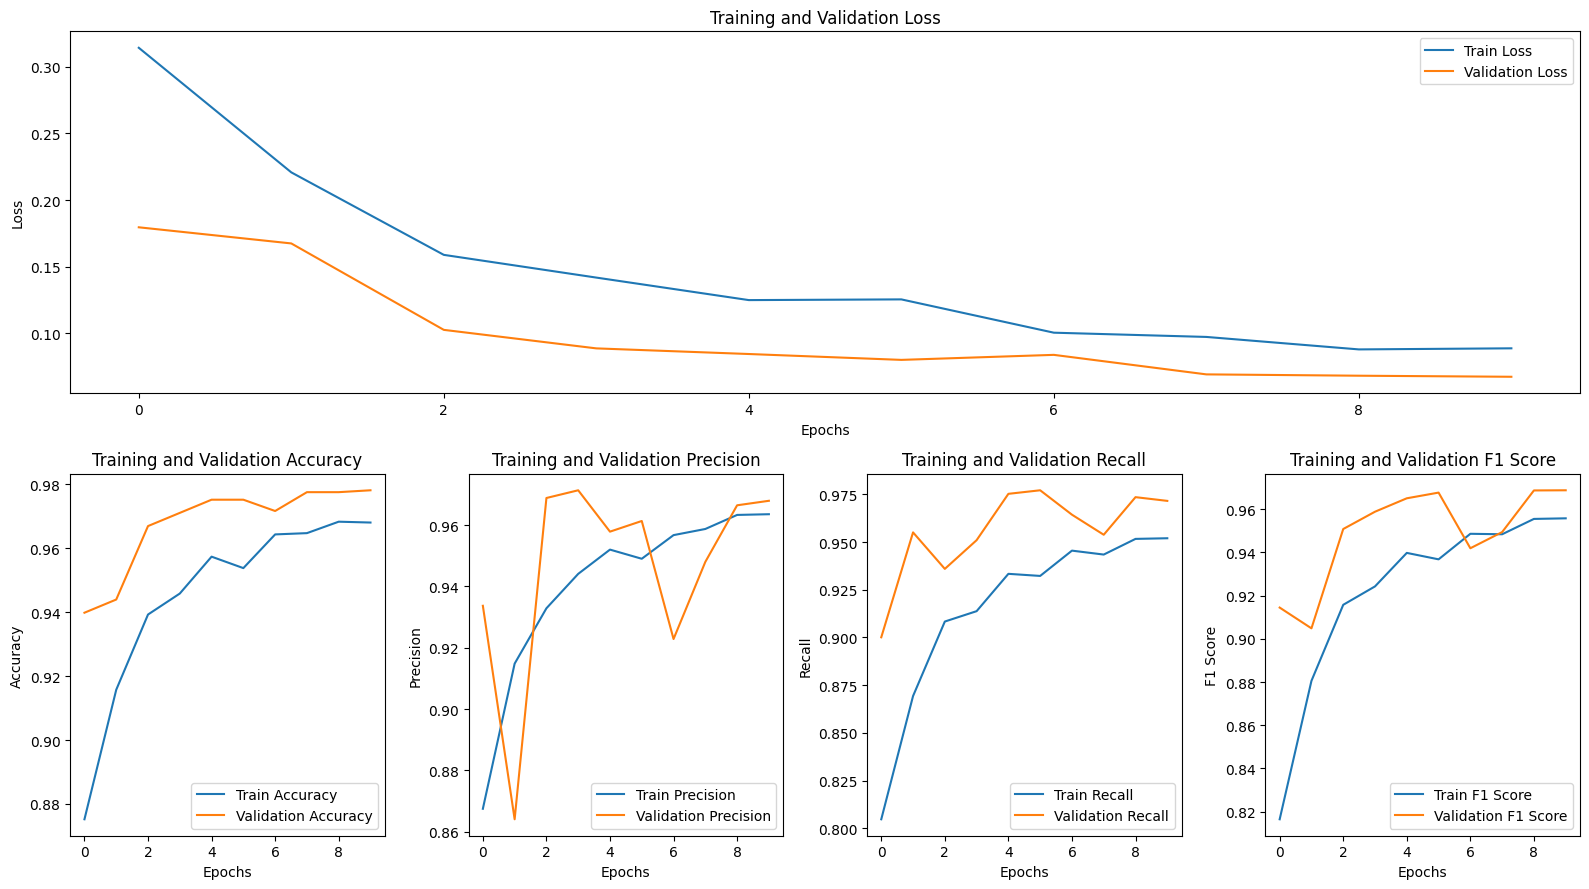

In [52]:
plot_training_history(train_loss_history, train_acc_history, train_precision_history, train_recall_history, train_f1_history, valid_loss_history, valid_acc_history, valid_precision_history, valid_recall_history, valid_f1_history)

In [55]:
# 모델 로드 함수 정의
def load_model(model_path, text_checkpoint, vision_checkpoint):
    model = MultiModalBERT(text_checkpoint, vision_checkpoint)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, pixel_values, y = batch
            input_ids, attention_mask, pixel_values, y = input_ids.to(device), attention_mask.to(device), pixel_values.to(device), y.to(device)

            outputs = model(input_ids, attention_mask, pixel_values)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    return preds_list, true_labels

In [56]:
# 저장된 모델 경로
best_model_path = path+'/YouTube_RoBERTa_ViT_ACC_0.9782.pth'

In [57]:
# 모델 불러오기
model = load_model(best_model_path, text_checkpoint, vision_checkpoint)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 53/53 [00:38<00:00,  1.37it/s]


In [63]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_precision = precision_score(true_labels, preds_list)
test_recall = recall_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)
test_cm = confusion_matrix(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print(f'Test Confusion Matrix: \n{test_cm}')

Test Accuracy: 0.9730
Test Precision: 0.9574
Test Recall: 0.9712
Test F1 Score: 0.9643
Test Confusion Matrix: 
[[1015   27]
 [  18  607]]
